In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay
)

os.makedirs("data", exist_ok=True)
os.makedirs("results", exist_ok=True)

df = pd.read_csv("data/sms_clean.csv") 
df = df[["text", "label"]].copy()       
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)

print(df.shape)
print(df["label"].value_counts())


(5171, 2)
label
0    4518
1     653
Name: count, dtype: int64


In [2]:
RANDOM_STATE = 42

X = df["text"].values
y = df["label"].values
idx = np.arange(len(df))

train_idx, temp_idx = train_test_split(
    idx, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.50, random_state=RANDOM_STATE, stratify=y[temp_idx]
)

np.savez("data/split_idx.npz", train_idx=train_idx, val_idx=val_idx, test_idx=test_idx)

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

len(X_train), len(X_val), len(X_test)


(3619, 776, 776)

In [5]:
vectorizer = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    min_df=2
)

models = {
    "TFIDF+MultinomialNB": Pipeline([
        ("tfidf", vectorizer),
        ("clf", MultinomialNB())
    ]),
    "TFIDF+LogReg": Pipeline([
        ("tfidf", vectorizer),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "TFIDF+LinearSVC": Pipeline([
        ("tfidf", vectorizer),
        ("clf", LinearSVC(class_weight="balanced"))
    ]),
}


In [7]:
def get_scores(model, X):
    # για ROC-AUC χρειαζόμαστε "score" (proba ή decision_function)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return None

def eval_one(name, model, X_tr, y_tr, X_ev, y_ev):
    model.fit(X_tr, y_tr)
    pred = model.predict(X_ev)
    score = get_scores(model, X_ev)

    out = {
        "model": name,
        "accuracy": accuracy_score(y_ev, pred),
        "precision_spam": precision_score(y_ev, pred, pos_label=1, zero_division=0),
        "recall_spam": recall_score(y_ev, pred, pos_label=1, zero_division=0),
        "f1_spam": f1_score(y_ev, pred, pos_label=1, zero_division=0),
        "roc_auc": roc_auc_score(y_ev, score) if score is not None else np.nan
    }
    return out, pred, score


In [9]:
rows = []
val_outputs = {}  # κρατάμε preds/scores για plots

for name, m in models.items():
    r, pred, score = eval_one(name, m, X_train, y_train, X_val, y_val)
    rows.append(r)
    val_outputs[name] = {"model": m, "pred": pred, "score": score}

metrics_val = pd.DataFrame(rows).sort_values(by="f1_spam", ascending=False)
metrics_val


,model,accuracy,precision_spam,recall_spam,f1_spam,roc_auc
2,TFIDF+LinearSVC,0.985825,0.948454,0.938776,0.943590,0.988757
1,TFIDF+LogReg,0.981959,0.920000,0.938776,0.929293,0.989314
0,TFIDF+MultinomialNB,0.957474,1.000000,0.663265,0.797546,0.985612


In [11]:
metrics_val.to_csv("results/baselines_metrics_val.csv", index=False)
print("Saved -> results/baselines_metrics_val.csv")


Saved -> results/baselines_metrics_val.csv


In [13]:
from sklearn.model_selection import ParameterGrid

best_name = metrics_val.iloc[0]["model"]
print("Best on val:", best_name)

if best_name == "TFIDF+LinearSVC":
    grid = ParameterGrid({"clf__C": [0.25, 0.5, 1.0, 2.0]})
    best = None
    best_row = None

    base = Pipeline([
        ("tfidf", vectorizer),
        ("clf", LinearSVC(class_weight="balanced"))
    ])

    for p in grid:
        base.set_params(**p)
        r, _, _ = eval_one(f"LinearSVC(C={p['clf__C']})", base, X_train, y_train, X_val, y_val)
        if best_row is None or r["f1_spam"] > best_row["f1_spam"]:
            best_row = r
            best = Pipeline([
                ("tfidf", vectorizer),
                ("clf", LinearSVC(class_weight="balanced", C=p["clf__C"]))
            ])

    print(best_row)
else:
    best = models[best_name]


Best on val: TFIDF+LinearSVC
{'model': 'LinearSVC(C=1.0)', 'accuracy': 0.9858247422680413, 'precision_spam': 0.9484536082474226, 'recall_spam': 0.9387755102040817, 'f1_spam': 0.9435897435897436, 'roc_auc': 0.9887574498826079}


In [15]:
best.fit(X_train, y_train)
test_pred = best.predict(X_test)
test_score = get_scores(best, X_test)

test_metrics = {
    "accuracy": accuracy_score(y_test, test_pred),
    "precision_spam": precision_score(y_test, test_pred, pos_label=1, zero_division=0),
    "recall_spam": recall_score(y_test, test_pred, pos_label=1, zero_division=0),
    "f1_spam": f1_score(y_test, test_pred, pos_label=1, zero_division=0),
    "roc_auc": roc_auc_score(y_test, test_score) if test_score is not None else np.nan
}
test_metrics


{'accuracy': 0.9871134020618557,
 'precision_spam': 0.9782608695652174,
 'recall_spam': 0.9183673469387755,
 'f1_spam': 0.9473684210526315,
 'roc_auc': 0.9925501173920895}

In [17]:
pd.DataFrame([test_metrics]).to_csv("results/best_baseline_metrics_test.csv", index=False)
print("Saved -> results/best_baseline_metrics_test.csv")


Saved -> results/best_baseline_metrics_test.csv


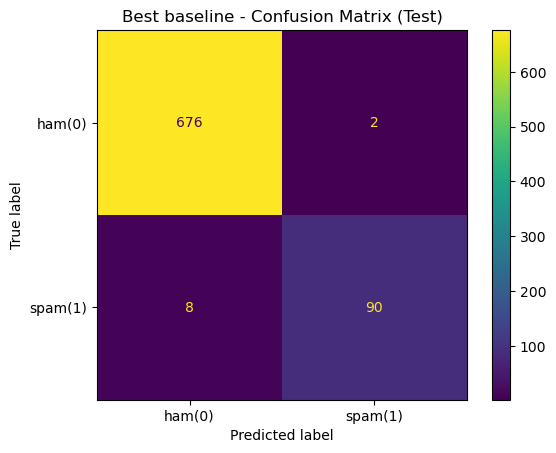

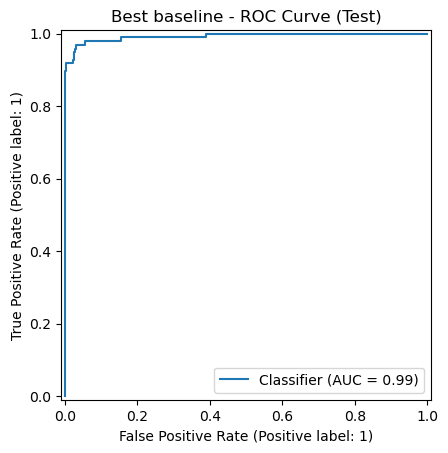

In [19]:
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["ham(0)", "spam(1)"])
disp.plot(values_format="d")
plt.title("Best baseline - Confusion Matrix (Test)")
plt.savefig("results/best_baseline_confusion_matrix.png", dpi=200, bbox_inches="tight")
plt.show()

# ROC Curve (μόνο αν έχουμε score)
if test_score is not None:
    RocCurveDisplay.from_predictions(y_test, test_score)
    plt.title("Best baseline - ROC Curve (Test)")
    plt.savefig("results/best_baseline_roc_curve.png", dpi=200, bbox_inches="tight")
    plt.show()


In [21]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

df = pd.read_csv("data/sms_clean.csv")[["text","label"]]
X = df["text"].astype(str).values
y = df["label"].astype(int).values

splits = np.load("data/split_idx.npz")
train_idx, test_idx = splits["train_idx"], splits["test_idx"]

best = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2)),
    ("clf", LinearSVC(class_weight="balanced"))
])

best.fit(X[train_idx], y[train_idx])
pred = best.predict(X[test_idx])

test_df = df.iloc[test_idx].copy()
test_df["pred"] = pred

fp = test_df[(test_df["label"]==0) & (test_df["pred"]==1)]
fn = test_df[(test_df["label"]==1) & (test_df["pred"]==0)]

fp.to_csv("results/errors_false_positives.csv", index=False)
fn.to_csv("results/errors_false_negatives.csv", index=False)

print("FP:", len(fp), "saved -> results/errors_false_positives.csv")
print("FN:", len(fn), "saved -> results/errors_false_negatives.csv")


FP: 2 saved -> results/errors_false_positives.csv
FN: 8 saved -> results/errors_false_negatives.csv


In [23]:
import numpy as np
import pandas as pd
from pathlib import Path

Path("results").mkdir(exist_ok=True)

# spam probability (SVC has decision_function)
if hasattr(best, "predict_proba"):
    spam_prob = best.predict_proba(X_test)[:, 1]
else:
    scores = best.decision_function(X_test)
    spam_prob = 1 / (1 + np.exp(-scores))

y_true = y_test.astype(int)
y_pred = (spam_prob >= 0.5).astype(int)

# per-example scores (for reproducibility + ROC)
pd.DataFrame({
    "text": X_test,
    "y_true": y_true,
    "spam_prob": spam_prob,
    "y_pred": y_pred
}).to_csv("results/baseline_test_scores.csv", index=False)

# FP/FN
pd.DataFrame({"text": X_test[(y_true==0) & (y_pred==1)]}).to_csv("results/baseline_false_positives.csv", index=False)
pd.DataFrame({"text": X_test[(y_true==1) & (y_pred==0)]}).to_csv("results/baseline_false_negatives.csv", index=False)

print("Saved -> results/baseline_test_scores.csv")
print("Saved -> results/baseline_false_positives.csv")
print("Saved -> results/baseline_false_negatives.csv")

Saved -> results/baseline_test_scores.csv
Saved -> results/baseline_false_positives.csv
Saved -> results/baseline_false_negatives.csv
